# Regression with EMProb for $\pi \pm$ with EM Info

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import process_time as cput
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUs Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K

## Load Data
Data does not include tracks

X = [Energy, Eta, Phi, rPerp, calo_layer]

Y = [EnergyEM, EnergyNonEM]

Yt = [truthPartE, all_cluster_ENG_CALIB_TOT]

In [3]:
t0 = cput()
Xraw = np.load('/data/atlas/rbate/PIPM_X_20_files.npy', mmap_mode='r')[:,:,:]
Yseg = np.load('/data/atlas/rbate/PIPM_Y_segm_20_files.npy', mmap_mode='r')[:,:,:]
Yreg = np.load('/data/atlas/rbate/PIPM_Y_regr_20_files.npy', mmap_mode='r')[:,:]
print(Xraw.shape)
print(Yseg.shape)
print(Yreg.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/X_PPM_EM_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))

Yem = np.lib.format.open_memmap('/data/atlas/rbate/Y_PPM_EM_notebook.npy',
                             mode='w+', dtype=np.float64, shape=Yseg.shape)
np.copyto(dst=Yem, src=Yseg, casting='same_kind', where=True)

# Energy_EM = np.ndarray.copy(Yraw[:,:,0])
# Energy_nonEM = np.ndarray.copy(Yraw[:,:,1])
nz_mask = Yseg[:,:,0] + Yseg[:,:,1] != 0 
print(np.shape(nz_mask))
print(np.count_nonzero(nz_mask.flatten()))

ratio = np.zeros((X.shape[0], X.shape[1]))
ratio[nz_mask] = Yem[nz_mask,0]/(Yem[nz_mask,0] + Yem[nz_mask,1])
ratio = ratio*2 - 1
print(ratio.shape)

X[nz_mask,:4] = np.ndarray.copy(Xraw[nz_mask,:4])
X[nz_mask,4] = np.ndarray.copy(ratio[nz_mask])
# np.copyto(dst=X[:,:,:4], src=Xraw[:,:,:4], casting='same_kind', where=nz_mask)
# np.copyto(dst=X[:,:,4], src=ratio, casting='same_kind', where=nz_mask)
# Make sure that non-zero elements are copied as zeros due to mis-match
X[np.invert(nz_mask),:] = 0

t1 = cput()

print('Time to load memory mapped data: {} (s)'.format(t1-t0))

(279232, 1117, 5)
(279232, 1117, 2)
(279232, 2)
(279232, 1117)
68390314
(279232, 1117)
Time to load memory mapped data: 121.463871277 (s)


In [4]:
active_points = np.count_nonzero(nz_mask)
print(active_points)
total_points = X.shape[0]*X.shape[1]
print(total_points)
print('Ratio of points in cloud per event: {:3.2f}'.format(active_points/total_points))

68390314
311902144
Ratio of points in cloud per event: 0.22


#### Normalize Target

In [5]:
## REGRESSION TARGET ##
Y = np.ndarray.copy(np.log(Yreg[:,0]))

#### Show Targets

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


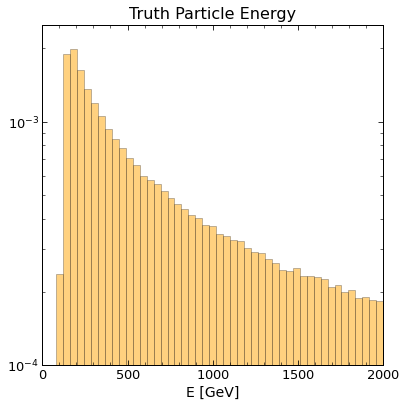

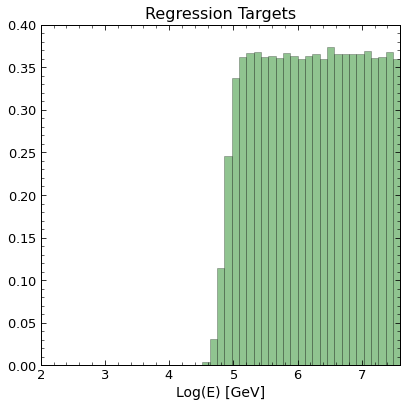

In [6]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yreg[:,0], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='Particle Truth Energy')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.0001,.0025)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(np.exp(2)), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.4)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

### Normalize Inputs

In [7]:
t0 = cput()
## Normalize rPerp to 1/3630
# rPerp_mask = X[nz_mask,3] != 0
X[nz_mask,3] = X[nz_mask,3]/3630.

## Energy Values that are not zero! This should coincide with the EM vals...
X[nz_mask,0] = np.log(X[nz_mask,0])
cellE_mean = np.mean(X[nz_mask,0])
cellE_std = np.std(X[nz_mask,0])
X[nz_mask,0] = (X[nz_mask,0] - cellE_mean)/cellE_std

## Eta and Phi
# eta_mask = X[:,:,1] != 0
X[nz_mask,1] = X[nz_mask,1]/.7

# phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[nz_mask,2])
X[nz_mask,2] = X[nz_mask,2]/cellPhi_std
t1 = cput()

print('Time to Normalize: {} (m)'.format((t1-t0)/60))

Time to Normalize: 0.4790329272666668 (m)


#### Plot Inputs

<Figure size 799.992x599.976 with 0 Axes>

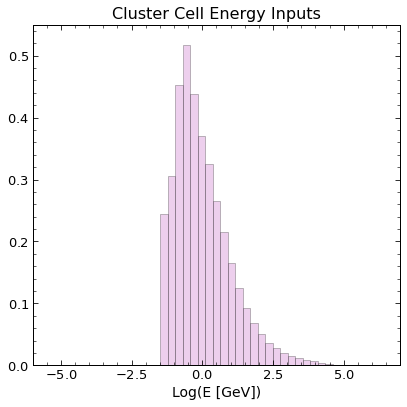

<Figure size 799.992x599.976 with 0 Axes>

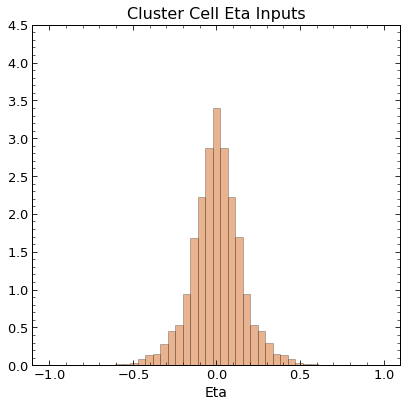

<Figure size 799.992x599.976 with 0 Axes>

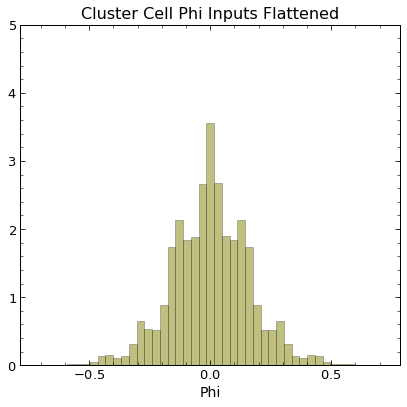

<Figure size 799.992x599.976 with 0 Axes>

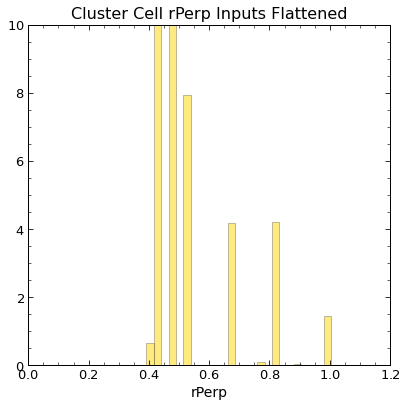

<Figure size 799.992x599.976 with 0 Axes>

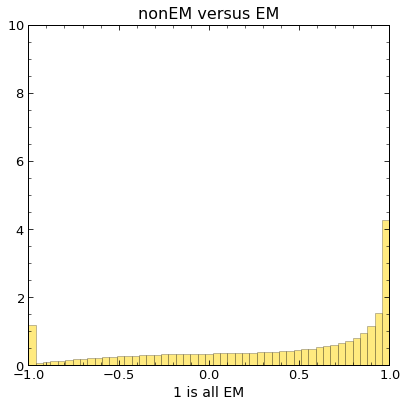

In [8]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[nz_mask,0], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_E_2021-07-26.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[nz_mask,1], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Eta_2021-07-26.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[nz_mask,2], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Phi_2021-07-26.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[nz_mask,3], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_rPerp_2021-07-26.png', format='png')
plt.show()

##############################
## HADRONIC VS NON HADRONIC ##
##############################
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
EMbins = np.linspace(-1,1,50, endpoint=True)
plt.hist(X[nz_mask,4], color='gold', bins=EMbins, density=True, alpha=.5, edgecolor='black')
plt.title('nonEM versus EM', fontsize=16)
plt.xlabel('1 is all EM', fontsize=14)
plt.xlim(-1,1)
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_rPerp_2021-07-26.png', format='png')
plt.show()

## Build Model

In [9]:
def point_mask_fn(X, mask_val=0.):
    return K.cast(K.any(K.not_equal(X, mask_val), axis=-1), K.dtype(X))

def ParticleFlow_base(num_points, num_features, name="Russell Flow Network"):
    
    inputs = keras.Input(shape=(num_points, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    masking_layer = layers.Masking(mask_value=0.0)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('relu', name="activation_6")(dense_6)
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

In [10]:
base_model = ParticleFlow_base(num_features=5, num_points=X.shape[1],
                               name='Base_PFN')
base_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
base_model.summary()

Model: "Base_PFN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1117, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 1117, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 1117, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 1117, 100)    10100       activation_0[0][0]               
___________________________________________________________________________________________

2022-01-18 23:13:49.719658: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-01-18 23:13:49.719721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


## Data Handling

In [11]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print('{} -- {} -- {}'.format(train, val, test))

train -- val -- test
195462 -- 41885 -- 41885


## Data Handling

### Shuffle Data

In [12]:
# indices = np.arange(X.shape[0], dtype=int)
# np.random.shuffle(indices)
# X = X[indices,:,:]
# Y = Y[indices]

### Train/Val/Test Split

In [13]:
X_train = X[:train,:,:]
Y_train = Y[:train]

X_val = X[train:train+val,:,:]
Y_val = Y[train:train+val]

X_test = X[train+val:,:,:]
Y_test = Y[train+val:]

# Print out tensor shapes
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
print(np.shape(X_train))
print(np.shape(Y_train))

(195462, 1117, 5)
(195462, 1)


## Train Model

In [14]:
num_epoch = 100
batch_size = 900

In [15]:
t0 = cput()
history_base = base_model.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)
t1 = cput()

2022-01-18 23:14:16.002974: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4366621080 exceeds 10% of free system memory.
2022-01-18 23:14:21.121481: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4366621080 exceeds 10% of free system memory.
2022-01-18 23:14:24.400308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
218/218 [==============================] - 17s 73ms/step - loss: 4.0549 - val_loss: 0.6109
Epoch 2/100
218/218 [==============================] - 13s 60ms/step - loss: 0.4589 - val_loss: 0.2494
Epoch 3/100
218/218 [==============================] - 14s 63ms/step - loss: 0.2601 - val_loss: 0.1631
Epoch 4/100
218/218 [==============================] - 14s 64ms/step - loss: 0.1894 - val_loss: 0.1274
Epoch 5/100
218/218 [==============================] - 14s 63ms/step - loss: 0.1422 - val_loss: 0.1138
Epoch 6/100
218/218 [==============================] - 14s 63ms/step - loss: 0.1290 - val_loss: 0.1055
Epoch 7/100
218/218 [==============================] - 14s 64ms/step - loss: 0.1223 - val_loss: 0.1686
Epoch 8/100
218/218 [==============================] - 13s 60ms/step - loss: 0.0979 - val_loss: 0.0725
Epoch 9/100
218/218 [==============================] - 14s 63ms/step - loss: 0.0915 - val_loss: 0.0721
Epoch 10/100
218/218 [==============================] - 14s 64ms/step - l

In [16]:
print('Time to train: {} (s)'.format(t1-t0))
print('{} (min)'.format((t1-t0)/60))
print('{} (hour)'.format((t1-t0)/3600))

Time to train: 1548.3133803370001 (s)
25.805223005616668 (min)
0.43008705009361115 (hour)


### Loss Curves

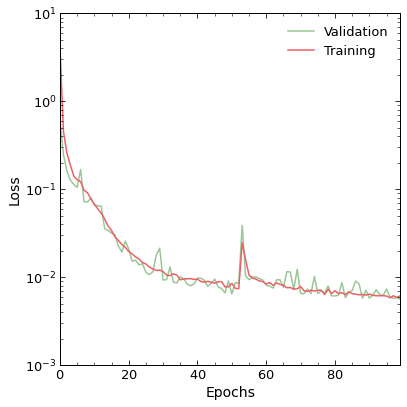

In [17]:
fig = plt.figure(figsize=(6,6))
plt.plot(history_base.history['val_loss'], label="Validation")
plt.plot(history_base.history['loss'], label="Training")
plt.yscale('log')
# plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,len(history_base.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/pipmNoEM_lossCurves_3000batch_LR1e-3_2021-11-29.png', format='png')
plt.show()

### Predictions

In [18]:
base_preds = base_model.predict(X_test, batch_size=batch_size).flatten()
print(base_preds.shape)

(41885,)


### Histogram of Predictions

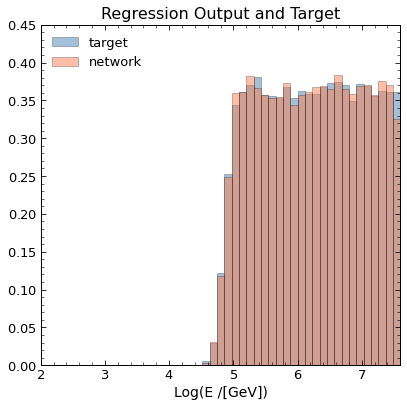

In [19]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(2,np.log(2000),50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(Y_test, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(base_preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(2,np.log(2000))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/NoEMtargetPreds_3000batch_LR1e-3_2021-11-29.png', format='png')
plt.show()

### Analytics

#### Response Plot

<Figure size 799.992x599.976 with 0 Axes>

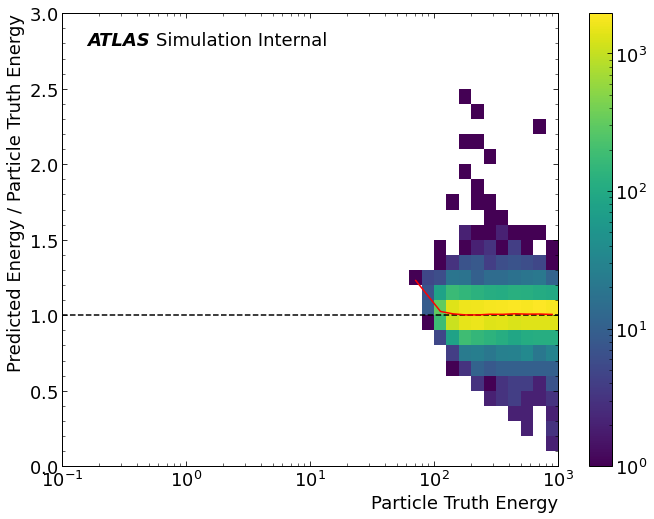

In [22]:
resplot = ru.responsePlot(x=np.exp(Y_test), y=np.exp(base_preds)/np.exp(Y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])

# Regression_Plots/November21/ResponsePlotNoEM_3000batch_LR1e-3_2021-11-29.png

#### Resolution Plot

<Figure size 799.992x599.976 with 0 Axes>

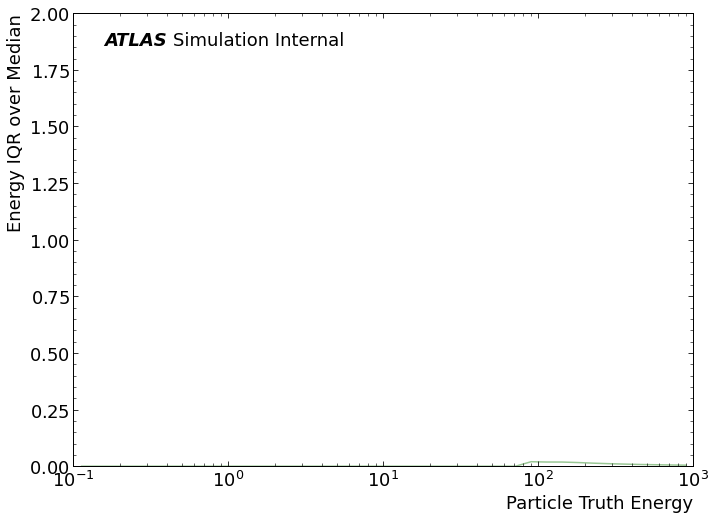

In [30]:
resp_plot = ru.resolutionPlot(x=np.exp(Y_test), y=10*base_preds/np.exp(Y_test),
                    figfile='Regression_Plots/November21/ResolutionPlotNoEM_3000batch_LR1e-3_2021-11-29.png',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])